In [28]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# libraries used for graph and visulization
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,10

# libraries used for missing value 
import missingno as msno



from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn.model_selection import cross_val_predict, KFold
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from imblearn.over_sampling import SMOTE,ADASYN,RandomOverSampler
from imblearn.pipeline import make_pipeline

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix,accuracy_score, roc_curve, precision_recall_curve, f1_score

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence

import xgboost as xgb


Load Data From CSV

In [29]:
pd_loan =pd.read_csv("Loan_cheker.csv")

In [30]:
pd_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
Id                             10000 non-null int64
is_bad                         10000 non-null int64
emp_title                      9408 non-null object
emp_length                     10000 non-null object
home_ownership                 10000 non-null object
annual_inc                     9999 non-null float64
verification_status            10000 non-null object
pymnt_plan                     10000 non-null object
Notes                          6770 non-null object
purpose_cat                    10000 non-null object
purpose                        9996 non-null object
zip_code                       10000 non-null object
addr_state                     10000 non-null object
debt_to_income                 10000 non-null float64
delinq_2yrs                    9995 non-null float64
earliest_cr_line               9995 non-null object
inq_last_6mths                 9995 non-null floa

Create Copy for dataframe for doing analysis

In [31]:
pd_analysis =pd_loan.copy()

In [105]:
pd_loan.head()

,Id,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,...,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
0,1,0,Time Warner Cable,10,MORTGAGE,50000.0,not verified,n,NaN,medical,...,NaN,15.0,0.0,12087,12.1,44.0,f,0.0,1,PC4
1,2,0,Ottawa University,1,RENT,39216.0,not verified,n,Borrower added on 04/14/11 > I will be using...,debt consolidation,...,NaN,4.0,0.0,10114,64.0,5.0,f,0.0,2,PC1
2,3,0,Kennedy Wilson,4,RENT,65000.0,not verified,n,NaN,credit card,...,NaN,4.0,0.0,81,0.6,8.0,f,0.0,3,PC4
3,4,0,TOWN OF PLATTEKILL,10,MORTGAGE,57500.0,not verified,n,NaN,debt consolidation,...,NaN,6.0,0.0,10030,37.1,23.0,f,0.0,2,PC2
4,5,0,Belmont Correctional,10,MORTGAGE,50004.0,VERIFIED - income,n,"I want to consolidate my debt, pay for a vacat...",debt consolidation,...,NaN,8.0,0.0,10740,40.4,21.0,f,0.0,3,PC3


# Show missing value in matrix 

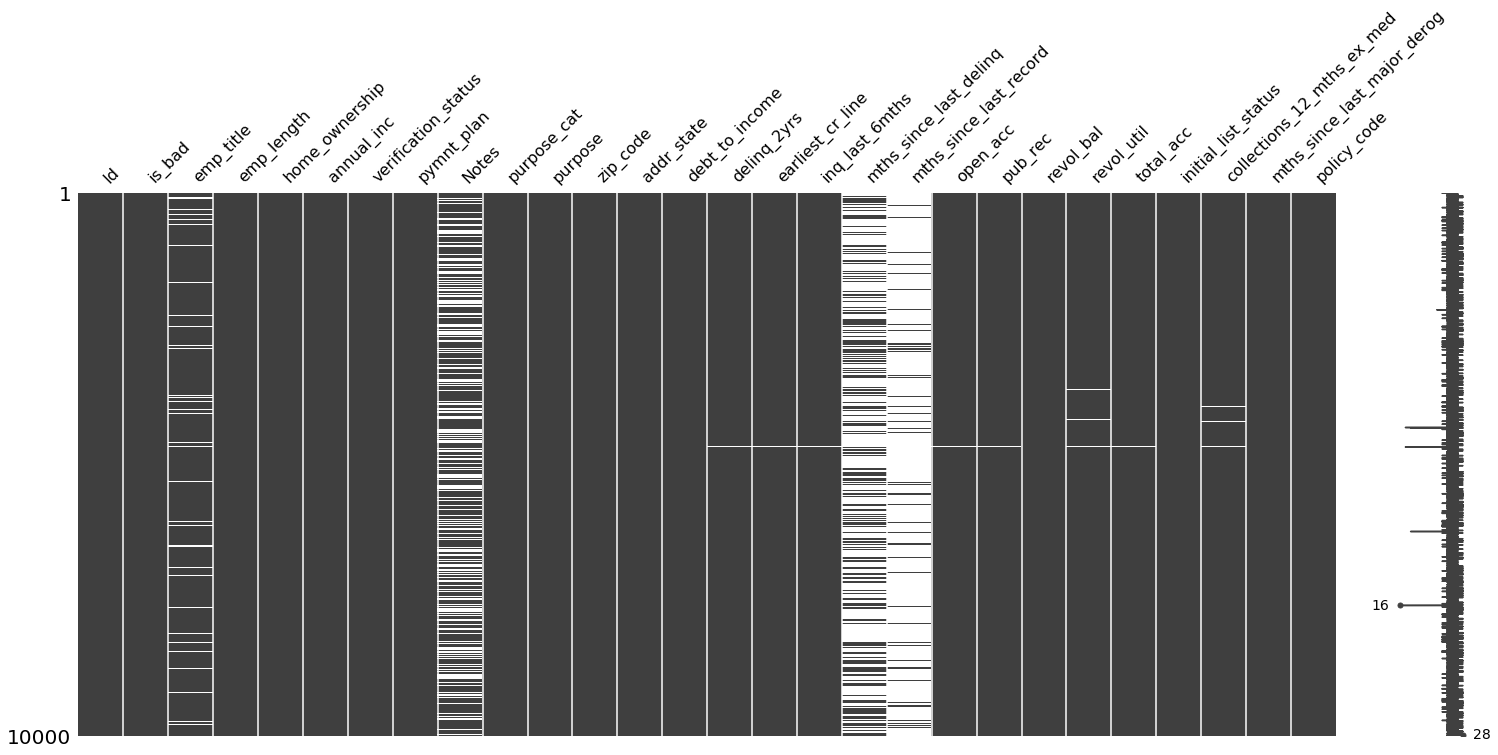

In [32]:
msno.matrix(pd_analysis)

In [33]:
pd_analysis.isnull().sum()

Id                                0
is_bad                            0
emp_title                       592
emp_length                        0
home_ownership                    0
annual_inc                        1
verification_status               0
pymnt_plan                        0
Notes                          3230
purpose_cat                       0
purpose                           4
zip_code                          0
addr_state                        0
debt_to_income                    0
delinq_2yrs                       5
earliest_cr_line                  5
inq_last_6mths                    5
mths_since_last_delinq         6316
mths_since_last_record         9160
open_acc                          5
pub_rec                           5
revol_bal                         0
revol_util                       26
total_acc                         5
initial_list_status               0
collections_12_mths_ex_med       32
mths_since_last_major_derog       0
policy_code                 

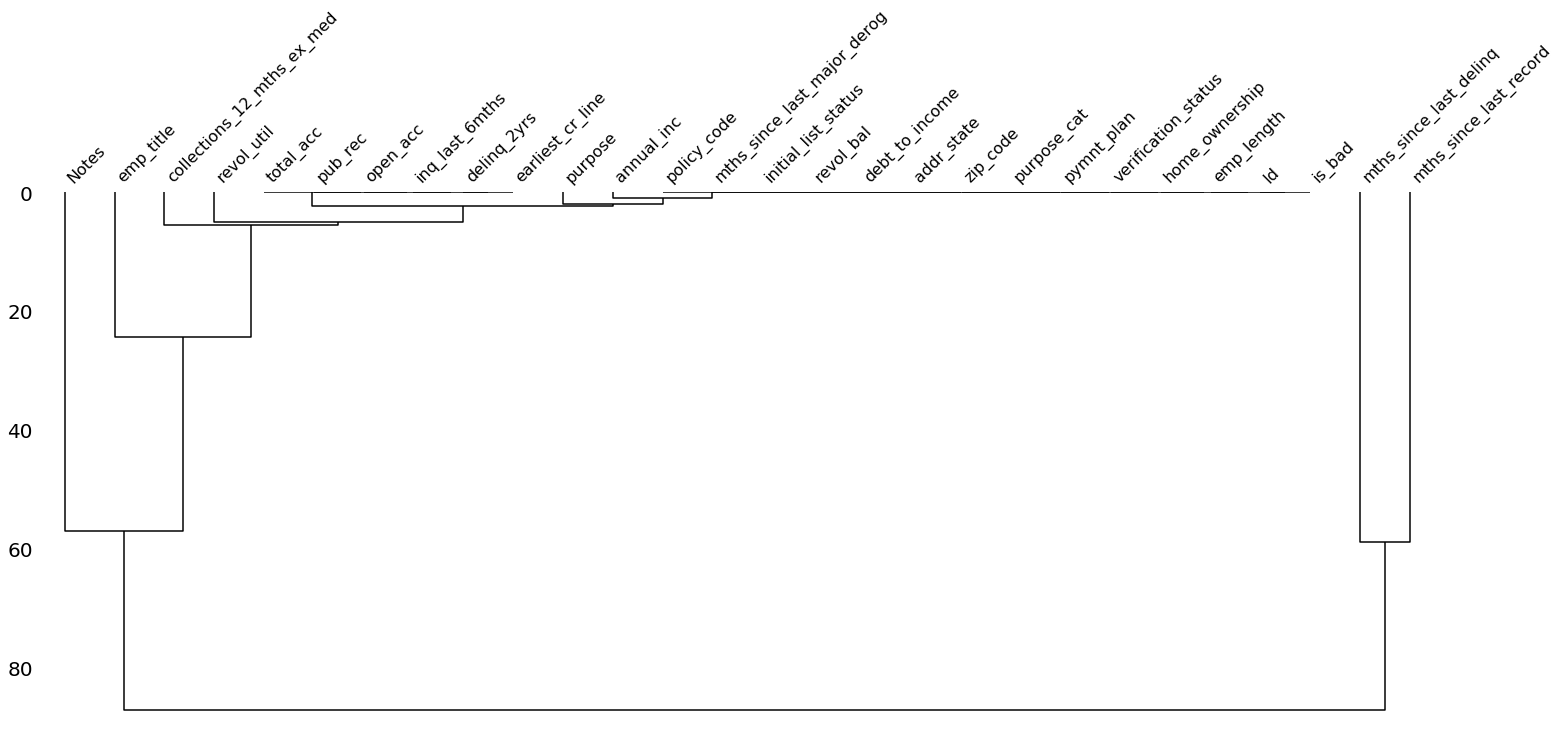

In [34]:
msno.dendrogram(pd_analysis)

Drop Cloumn with 63 % NULL Value

In [35]:
def percentage_missing_value(dataframe):
    """
        This function will return the percentage of missing values in a dataset 
        If column has over 80% missing value, del that column
    """
    if isinstance(dataframe,pd.DataFrame):
        adict={} #a dictionary conatin keys columns names and values percentage of missin value in the columns
        column = []
        for col in dataframe.columns:
            adict[col]=(np.count_nonzero(dataframe[col].isnull())*100)/len(dataframe[col])
            if adict[col] > 63:
                del adict[col]
            else:
                column.append(col)
        dataframe = dataframe.loc[:, column]
        return dataframe
    else:
        raise TypeError("method support dataframe only")
        

In [36]:
pd_analysis =percentage_missing_value(pd_analysis)

In [37]:
pd_analysis.drop(['Notes', 'emp_title','purpose','earliest_cr_line','Id','collections_12_mths_ex_med','initial_list_status'], axis=1,inplace=True)

# collections_12_mths_ex_med removed because there is no variation of data all are value as 0
# ID ,emp_title remove as the identity column of the lender person
# purpose is sub catagory of purpose_cat hence removing purpose

In [38]:
# As most of the records which has public pub record is NA are also Missing so we can consider those 5 record for the removeal
pd_analysis = pd_analysis[pd_analysis.pub_rec.notnull()]

In [39]:
group_object_cloumn  = pd_analysis.columns.to_series().groupby(pd_analysis.dtypes).groups

In [40]:
group_object_cloumn

{dtype('int64'): Index(['is_bad', 'revol_bal', 'mths_since_last_major_derog'], dtype='object'),
 dtype('float64'): Index(['annual_inc', 'debt_to_income', 'delinq_2yrs', 'inq_last_6mths',
        'open_acc', 'pub_rec', 'revol_util', 'total_acc'],
       dtype='object'),
 dtype('O'): Index(['emp_length', 'home_ownership', 'verification_status', 'pymnt_plan',
        'purpose_cat', 'zip_code', 'addr_state', 'policy_code'],
       dtype='object')}

In [41]:
# emp_length has 250 missing value so we need to have to fill na value 

pd_analysis['emp_length'] = pd.to_numeric(pd_analysis['emp_length'], errors='coerce')

In [42]:
# fill the emp_length based on the group by annual salary of the person

median_value=pd_analysis['emp_length'].median()
pd_analysis['emp_length'] =pd_analysis['emp_length'].fillna(median_value)

In [43]:
pd_analysis.isnull().sum()

is_bad                          0
emp_length                      0
home_ownership                  0
annual_inc                      0
verification_status             0
pymnt_plan                      0
purpose_cat                     0
zip_code                        0
addr_state                      0
debt_to_income                  0
delinq_2yrs                     0
inq_last_6mths                  0
open_acc                        0
pub_rec                         0
revol_bal                       0
revol_util                     21
total_acc                       0
mths_since_last_major_derog     0
policy_code                     0
dtype: int64

In [44]:
for i in pd_analysis._get_numeric_data().columns:
    pd_analysis[i] = pd_analysis[i].fillna(pd_analysis[i].median())
    
#need to consider the outier before updating to median check back 

In [45]:
pd_analysis.purpose_cat.unique()

array(['medical', 'debt consolidation', 'credit card', 'other', 'car',
       'wedding', 'other small business', 'house', 'small business',
       'educational', 'major purchase', 'home improvement', 'vacation',
       'debt consolidation small business', 'moving',
       'credit card small business', 'wedding small business',
       'small business small business', 'home improvement small business',
       'major purchase small business', 'educational small business',
       'house small business', 'renewable energy',
       'moving small business', 'medical small business',
       'vacation small business', 'car small business'], dtype=object)

### Visulization and Feature Engineering

Why people taking loan ?

Text(60.0, 0.5, 'status')

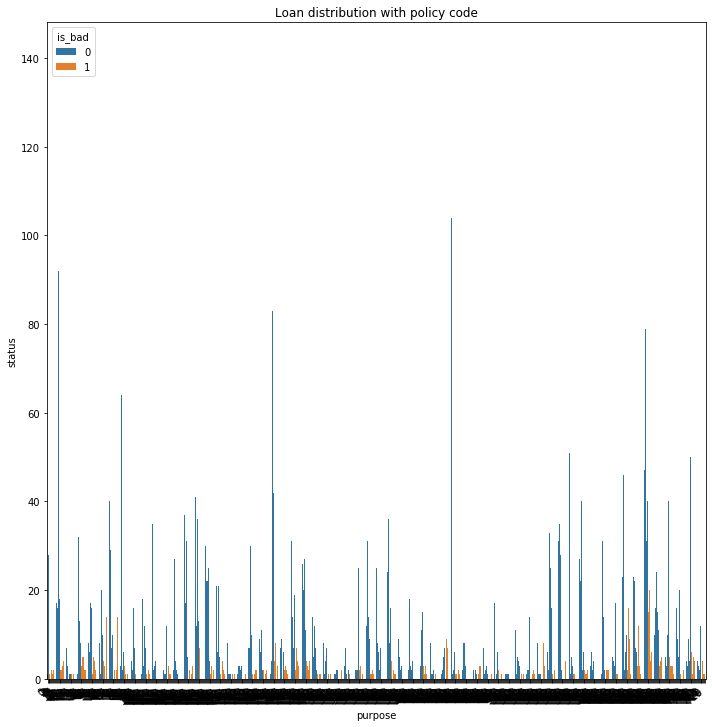

In [102]:
ax =sns.countplot(data=pd_analysis,hue='is_bad',x='zip_code')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Loan distribution with zip code')
plt.xlabel('zip_code',)
plt.ylabel('is_bad')

Text(53.75, 0.5, 'status')

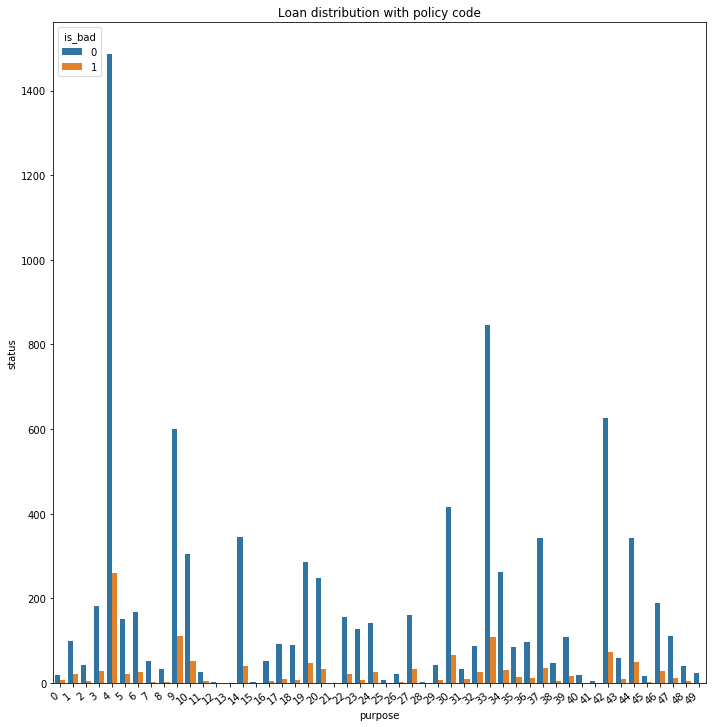

In [104]:
ax =sns.countplot(data=pd_analysis,hue='is_bad',x='addr_state')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Loan distribution with policy code')
plt.xlabel('purpose',)
plt.ylabel('status')

In [46]:
loan_purposes = pd_analysis.purpose_cat.value_counts()

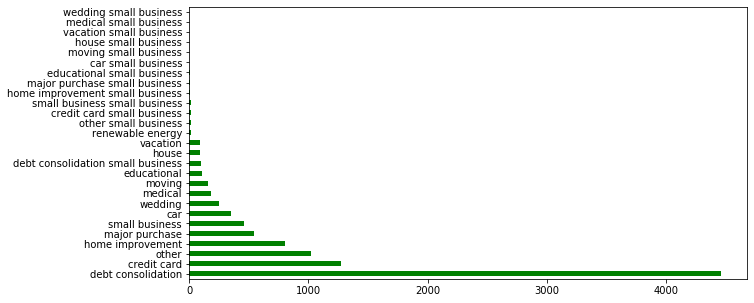

In [47]:
loan_purposes.plot.barh(figsize =(10,5),color ="green")

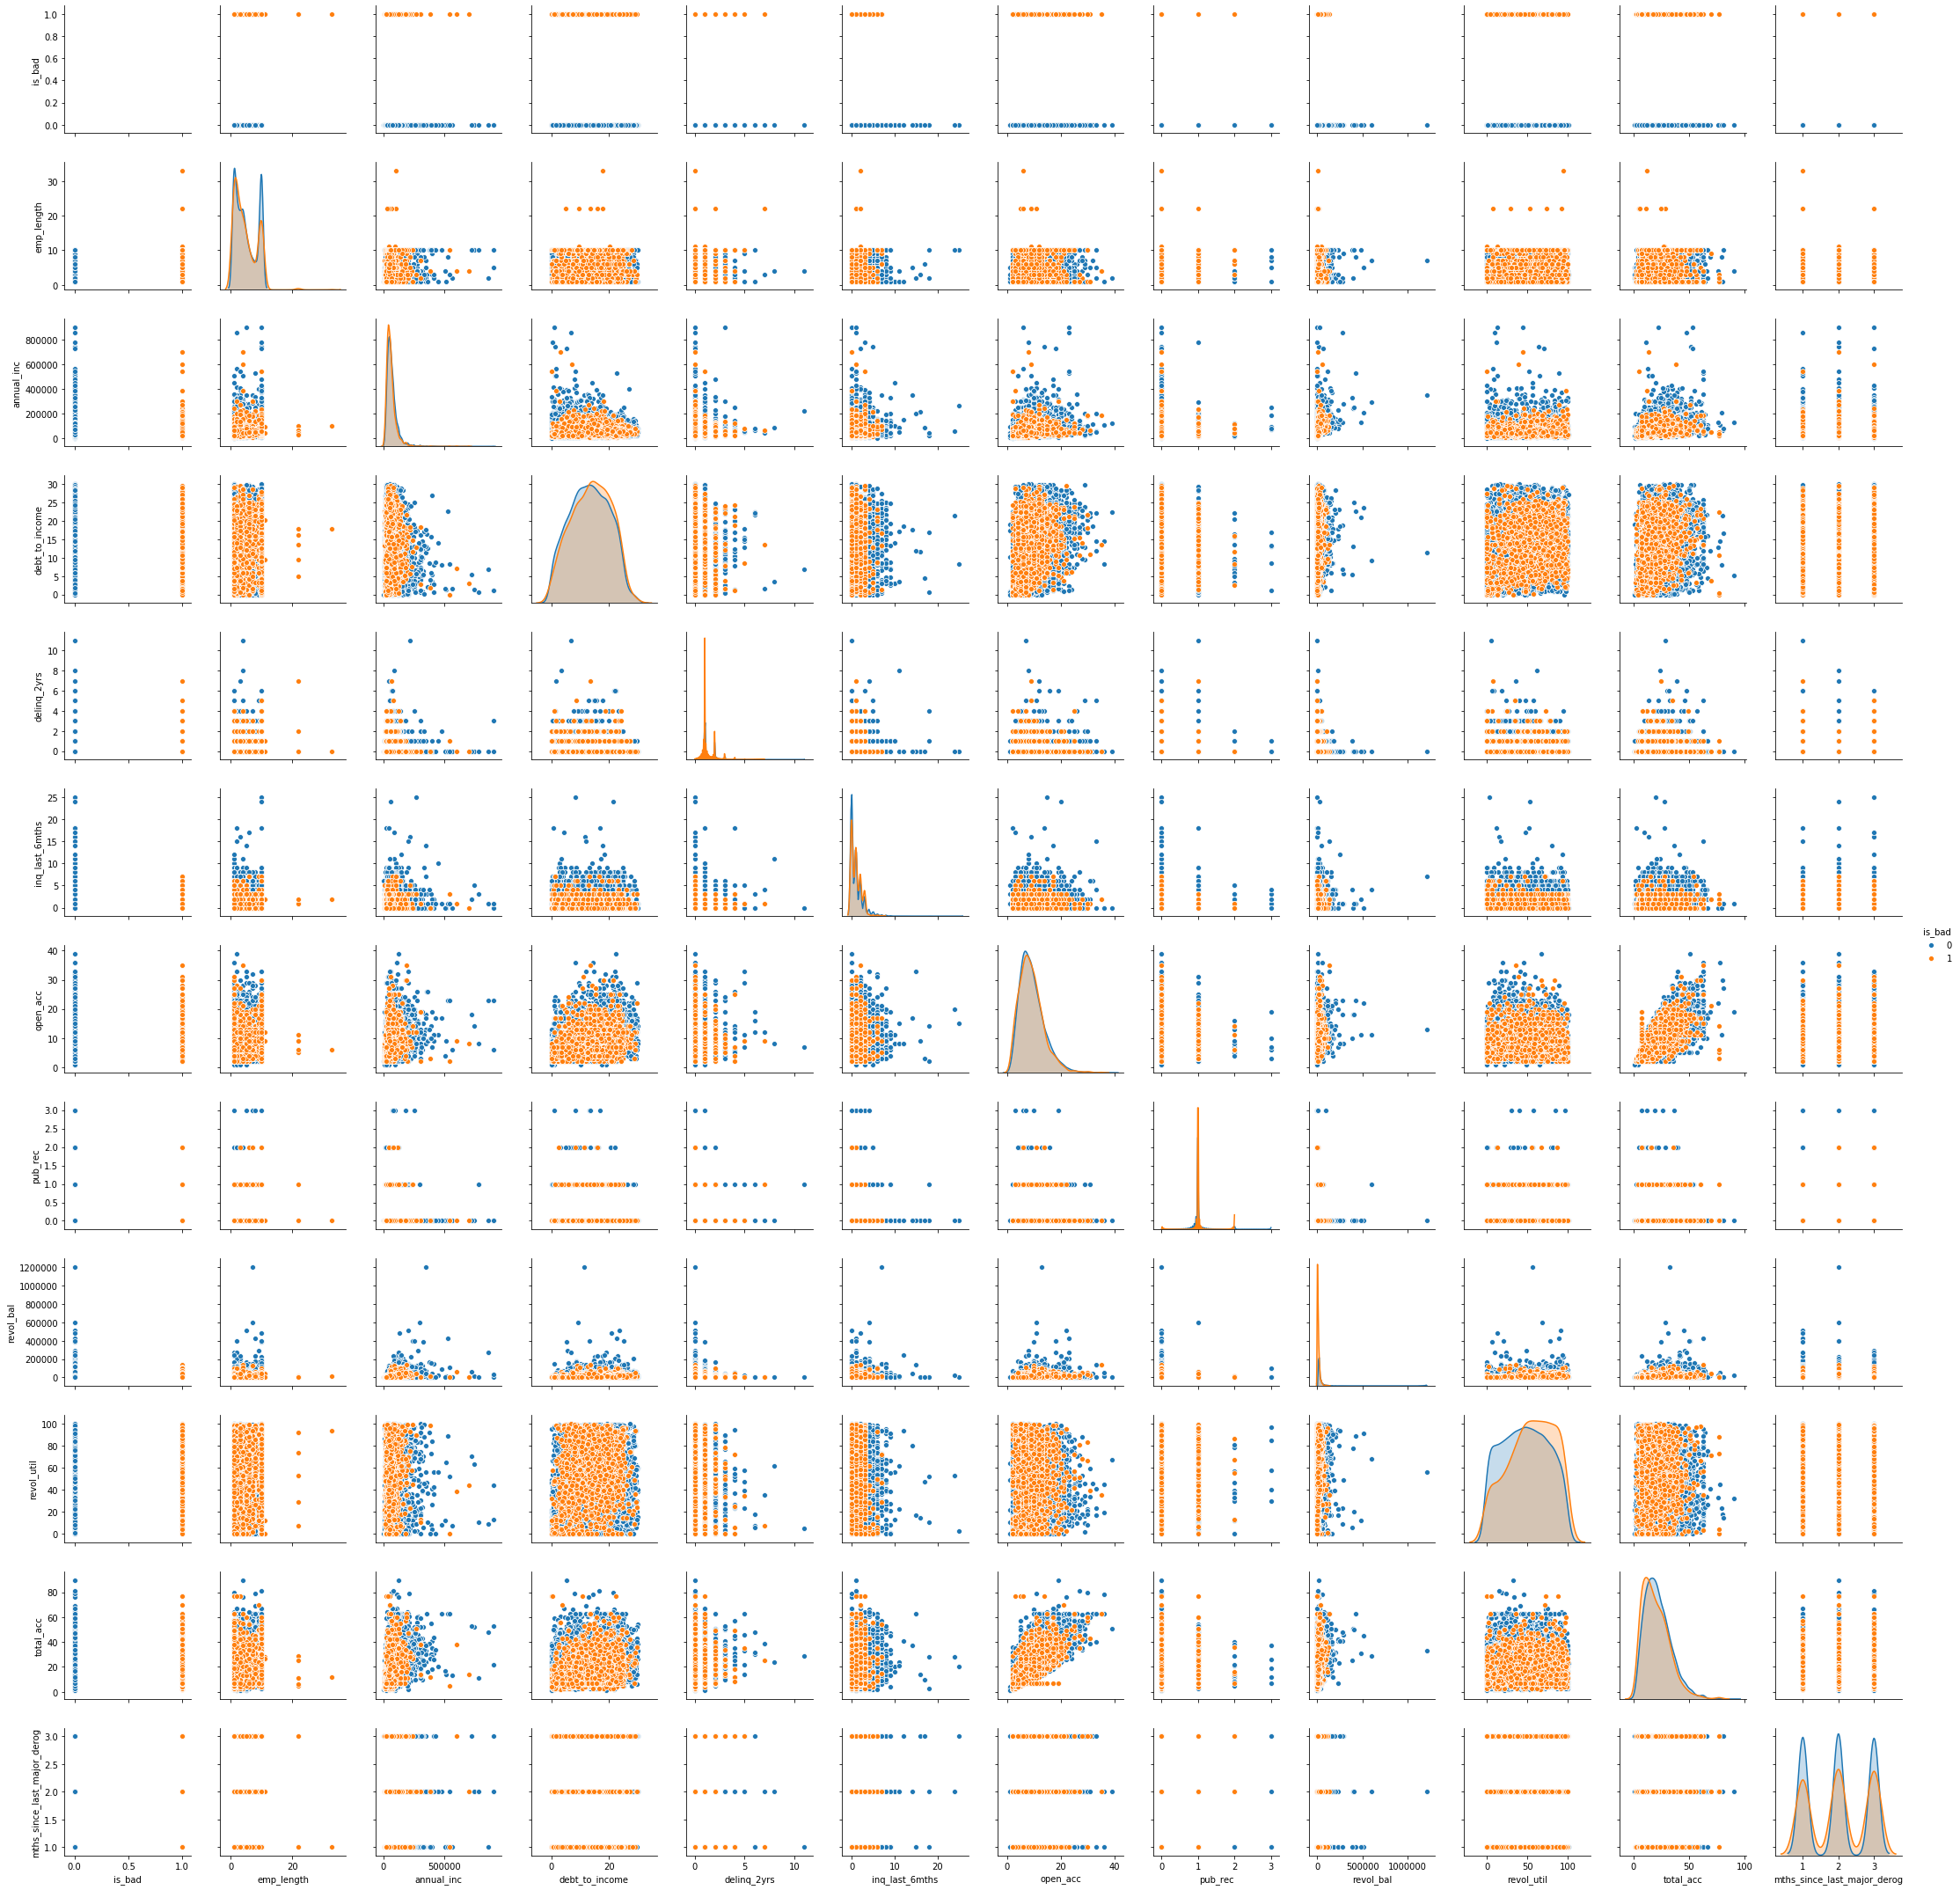

In [48]:
sns.pairplot(pd_analysis,hue ="is_bad")

Text(53.75, 0.5, 'status')

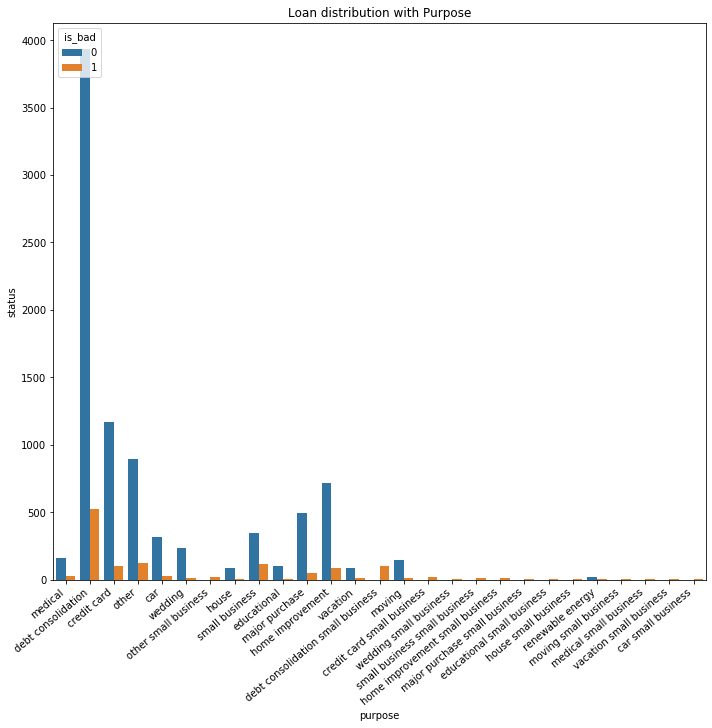

In [49]:
ax =sns.countplot(data=pd_analysis,hue='is_bad',x='purpose_cat')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Loan distribution with Purpose')
plt.xlabel('purpose',)
plt.ylabel('status')

Text(0, 0.5, 'status')

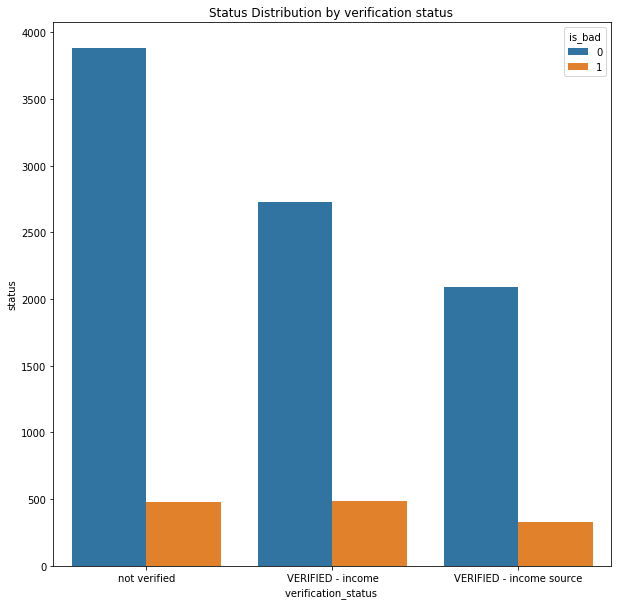

In [50]:
ax =sns.countplot(data=pd_analysis,hue='is_bad',x='verification_status')
plt.title('Status Distribution by verification status ')
plt.xlabel('verification_status ',)
plt.ylabel('status')

In [51]:
pd_no_encoder =pd_analysis.copy()

In [52]:
obj_df = pd_analysis.select_dtypes(include=['object']).copy()
obj_df.head()

,home_ownership,verification_status,pymnt_plan,purpose_cat,zip_code,addr_state,policy_code
0,MORTGAGE,not verified,n,medical,766xx,TX,PC4
1,RENT,not verified,n,debt consolidation,660xx,KS,PC1
2,RENT,not verified,n,credit card,916xx,CA,PC4
3,MORTGAGE,not verified,n,debt consolidation,124xx,NY,PC2
4,MORTGAGE,VERIFIED - income,n,debt consolidation,439xx,OH,PC3


In [53]:
for col in obj_df.columns:
    print(col,":",len(obj_df[col].unique()),'lables')

home_ownership : 4 lables
verification_status : 3 lables
pymnt_plan : 2 lables
purpose_cat : 27 lables
zip_code : 720 lables
addr_state : 50 lables
policy_code : 5 lables


In [54]:
# Create dummy variables from the feature pymnt_plan
pd_analysis = pd.get_dummies(pd_analysis, columns=["pymnt_plan"], drop_first=True)

# Create dummy variables from the feature purpose_cat
pd_analysis = pd.get_dummies(pd_analysis, columns=["purpose_cat"], drop_first=True)

# Create dummy variables from the feature home_ownership 
pd_analysis = pd.get_dummies(pd_analysis, columns=["home_ownership"], drop_first=True)

# Create dummy variables from the feature verification_status
pd_analysis = pd.get_dummies(pd_analysis, columns=["verification_status"], drop_first=True)

policy_code = LabelEncoder()
pd_analysis['policy_code'] = policy_code.fit_transform(pd_analysis['policy_code'])

In [55]:
from sklearn.preprocessing import LabelEncoder

state_add = LabelEncoder()
pd_analysis['addr_state'] = state_add.fit_transform(pd_analysis['addr_state'])

verification_status = LabelEncoder()
pd_analysis['zip_code'] = verification_status.fit_transform(pd_analysis['zip_code'])


In [56]:
pd_analysis.head()

,is_bad,emp_length,annual_inc,zip_code,addr_state,debt_to_income,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,purpose_cat_small business small business,purpose_cat_vacation,purpose_cat_vacation small business,purpose_cat_wedding,purpose_cat_wedding small business,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_VERIFIED - income source,verification_status_not verified
0,0,10.0,50000.0,555,42,10.87,0.0,0.0,15.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,1.0,39216.0,487,16,9.15,0.0,2.0,4.0,0.0,...,0,0,0,0,0,0,0,1,0,1
2,0,4.0,65000.0,649,4,11.24,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,1,0,1
3,0,10.0,57500.0,88,33,6.18,1.0,0.0,6.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,10.0,50004.0,348,34,19.03,0.0,4.0,8.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Feature Seleciton Process

In [57]:
pd_feature_selection =pd_analysis.copy()

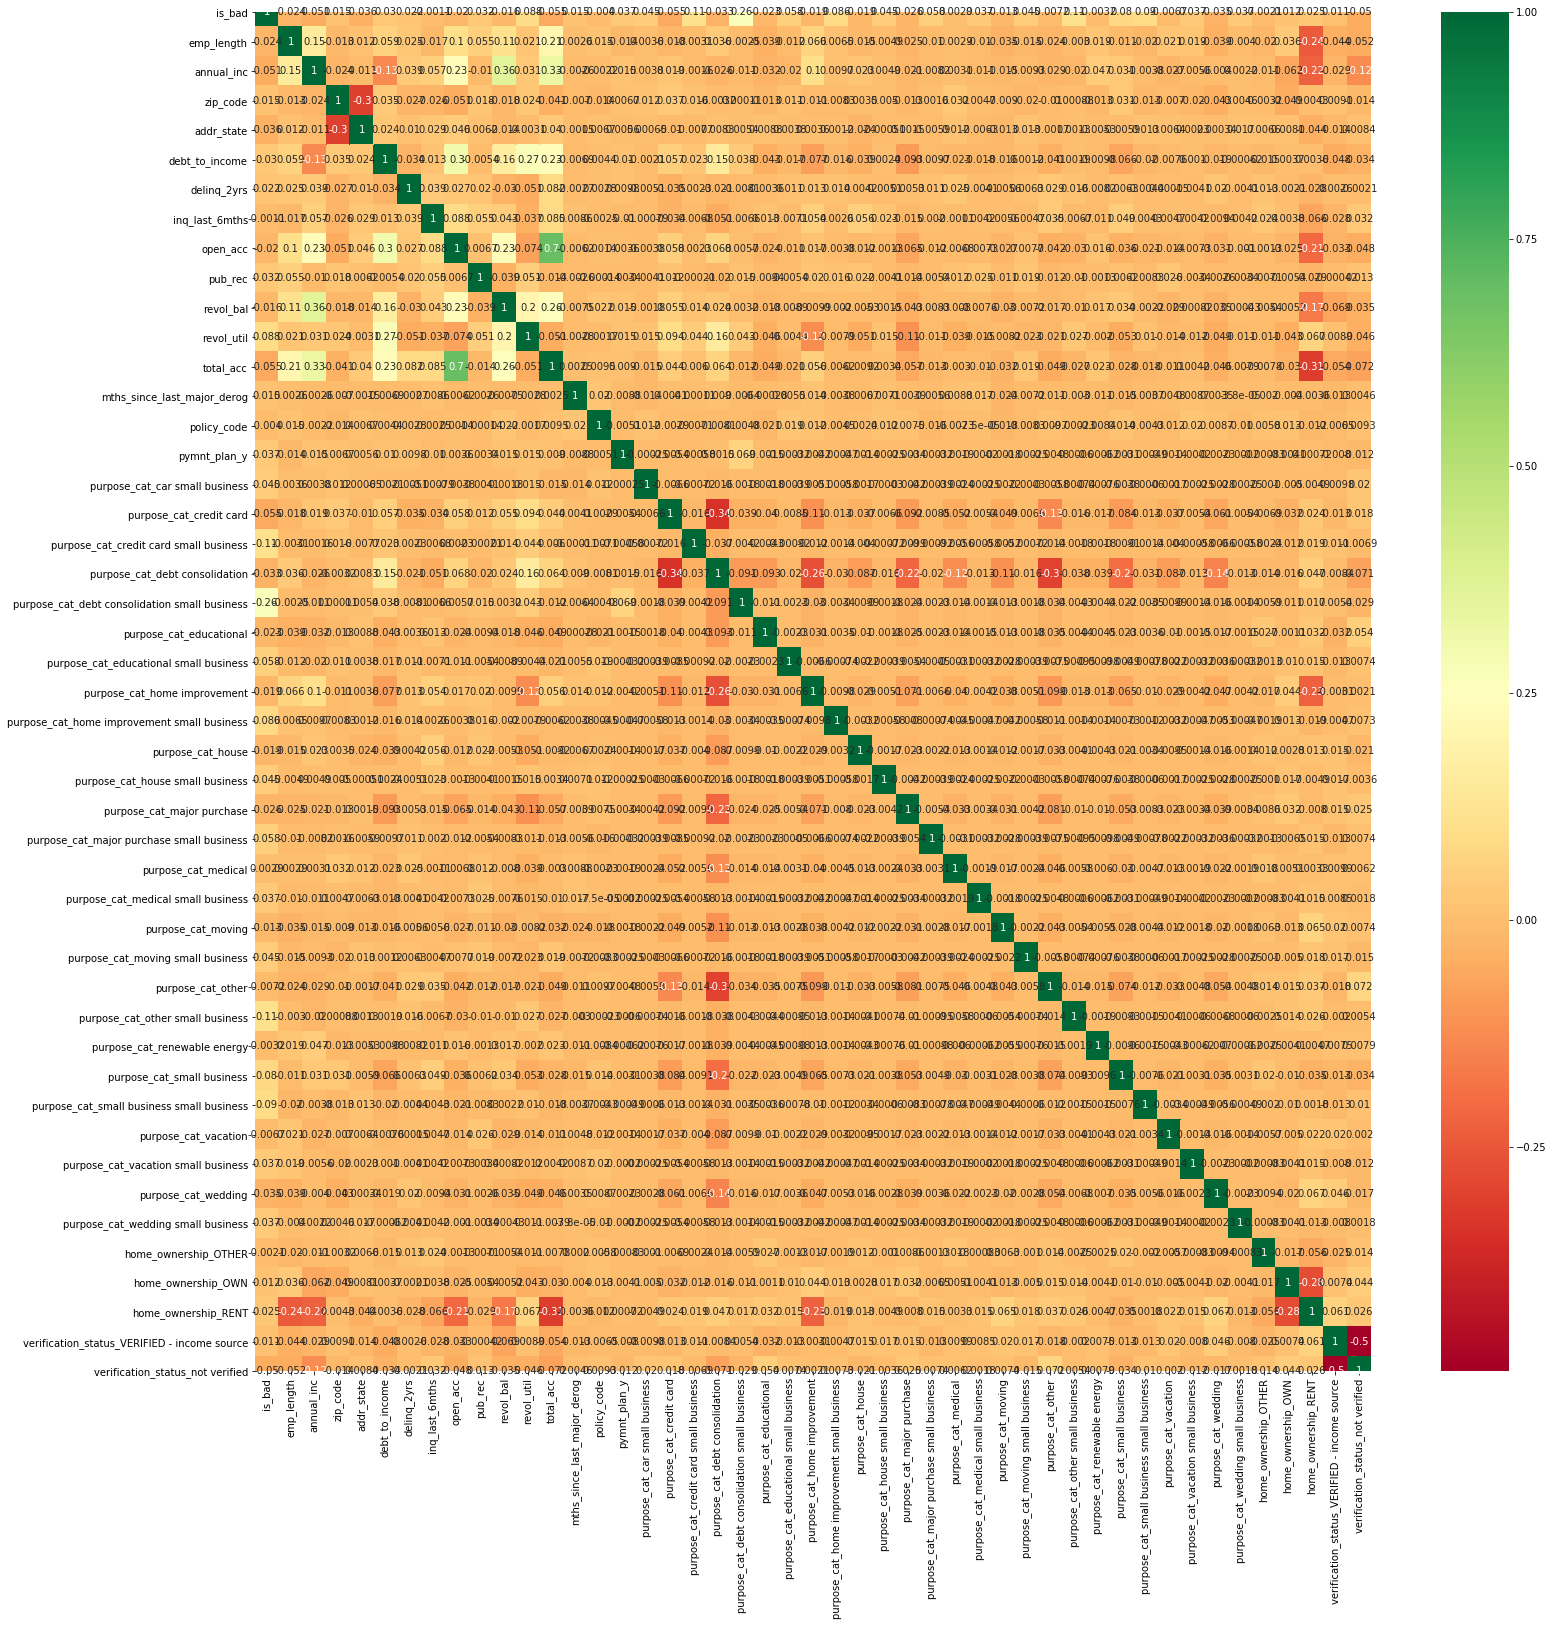

In [58]:
corrmat = pd_feature_selection.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(25,25))
#plot heat map
g=sns.heatmap(pd_feature_selection[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [59]:
# Original Data
X = pd_feature_selection.loc[:, pd_feature_selection.columns != "is_bad"].values
y = pd_feature_selection.loc[:, pd_feature_selection.columns == "is_bad"].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, shuffle=True, random_state=43, stratify=y)
print(f"Original data shapes: {X_train.shape, X_test.shape}")

Original data shapes: ((7996, 46), (1999, 46))


In [60]:
# Build random forest classifier
rf_clf = RandomForestClassifier(n_estimators=550, max_features=0.5,
                                criterion="entropy", class_weight="balanced",n_jobs=-1)

pip_baseline = make_pipeline(RobustScaler(), rf_clf)
scores = cross_val_score(pip_baseline,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Random forest model's average AUC: {scores.mean():.3f}")

Random forest model's average AUC: 0.682


[4.27633416e-02 9.96554849e-02 8.87558071e-02 5.45046157e-02
 1.00033622e-01 1.00037448e-02 3.95450713e-02 6.09200675e-02
 5.71498553e-03 9.85518359e-02 1.14120690e-01 8.13095915e-02
 2.11341240e-02 3.24932804e-02 1.36894304e-04 4.52484654e-04
 9.02510132e-03 5.22574895e-03 1.03128198e-02 3.82293245e-02
 8.87352531e-04 4.96690076e-04 4.76190147e-03 2.85666000e-03
 9.23684181e-04 1.03099979e-04 3.92654564e-03 5.62775543e-04
 1.79960421e-03 2.03134351e-04 1.53037521e-03 6.01192278e-04
 6.97729793e-03 3.78123817e-03 2.89070848e-04 1.13090413e-02
 1.89201879e-03 9.00617184e-04 3.25671642e-04 2.70242403e-03
 4.72729307e-04 6.06956762e-04 5.65696749e-03 1.17032379e-02
 9.39306871e-03 1.24480082e-02]


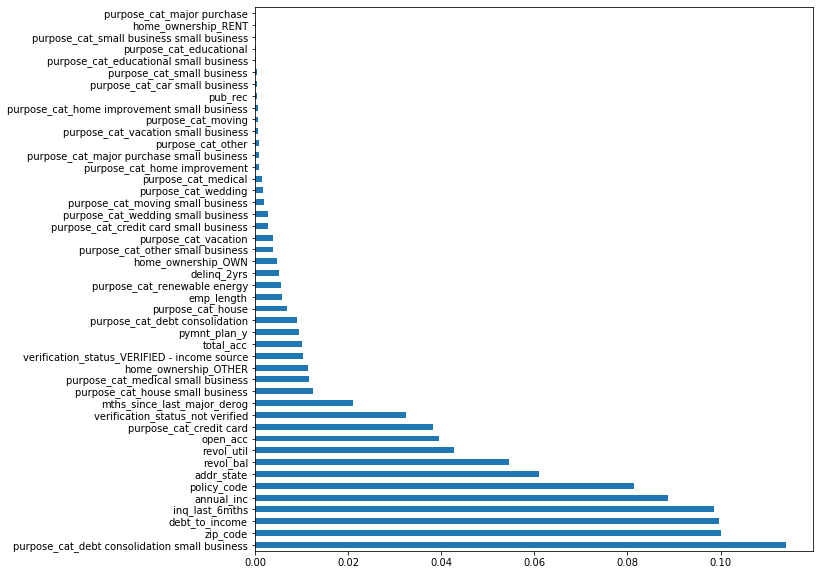

In [61]:
# fit RF to plot feature importances
rf_clf.fit(RobustScaler().fit_transform(X_train), y_train)

# Plot features importance
importances = rf_clf.feature_importances_
indices = np.argsort(rf_clf.feature_importances_)[::-1]
print(rf_clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(rf_clf.feature_importances_, index=pd_feature_selection.columns[pd_feature_selection.columns != "is_bad"][indices],)
feat_importances.nlargest(47).plot(kind='barh')
plt.show()

In [62]:
all_feature_list = feat_importances.nlargest(37).index

In [63]:
pd_feature_selection = pd_feature_selection[feat_importances.nlargest(37).index] 

In [64]:
pd_feature_selection.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9995 entries, 0 to 9999
Data columns (total 37 columns):
purpose_cat_debt consolidation small business    9995 non-null uint8
zip_code                                         9995 non-null int32
debt_to_income                                   9995 non-null float64
inq_last_6mths                                   9995 non-null float64
annual_inc                                       9995 non-null float64
policy_code                                      9995 non-null int32
addr_state                                       9995 non-null int32
revol_bal                                        9995 non-null int64
revol_util                                       9995 non-null float64
open_acc                                         9995 non-null float64
purpose_cat_credit card                          9995 non-null uint8
verification_status_not verified                 9995 non-null uint8
mths_since_last_major_derog                      9995 n

In [65]:
pd_analysis['is_bad'].value_counts() / pd_analysis.shape[0]

0    0.870435
1    0.129565
Name: is_bad, dtype: float64

The value_counts shows a significant class imbalance in the target column - more than 87% of the loans were paid on time.

Try OverSampling Method

In [66]:
# Change the data set based on feature importance  Data
X = pd_feature_selection.values
y = pd_analysis['is_bad'].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=43, stratify=y)
print(f"Original data shapes: {X_train.shape, X_test.shape}")

Original data shapes: ((7996, 37), (1999, 37))


In [67]:
rf_clf = RandomForestClassifier(n_estimators=550, max_features=0.5,
                                criterion="entropy", class_weight="balanced",n_jobs=-1)

rf_smote_pipline = make_pipeline(RobustScaler(),SMOTE() ,rf_clf)
scores = cross_val_score(rf_smote_pipline,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Random forest model's average AUC: {scores.mean():.3f}")

Random forest model's average AUC: 0.625


In [68]:
# Build model with oversampling
rf_oversample = make_pipeline( RobustScaler(),
                                   RandomOverSampler(),
                                   rf_clf)
scores = cross_val_score(rf_oversample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"Over-sampled model's average AUC: {scores.mean():.3f}")

Over-sampled model's average AUC: 0.663


Build Ensemble models
We’ll build ensemble models using three different models as base learners:
Gradient Boosting
Support Vector Classifier
Random Forest
The ensemble models will be built using two different methods:
Blending (average) ensemble model. Fits the base learners to the training data and then, at test time, average the predictions generated by all the base learners. Use VotingClassifier from sklearn that:
Fits all the base learners on the training data
At test time, use all base learners to predict test data and then take the average of all predictions.

In [69]:
# Standardize the data
std = RobustScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

In [70]:
random_over_sampler = RandomOverSampler()
X_over_sample, y_over_sample = random_over_sampler.fit_sample(X_train, y_train)

In [71]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_model = make_pipeline(StandardScaler(), 
                    RandomizedSearchCV(RandomForestClassifier(), 
                    param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1))


# Fit the random search model
rf_model.fit(X_train, y_train)


{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.0min finished


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomizedsearchcv',
                 RandomizedSearchCV(cv=3, error_score=nan,
                                    estimator=RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                                     max_leaf_nodes=None,
                                                                     max_samples=None,
                                                                     min_

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1740
           1       0.98      0.15      0.27       259

    accuracy                           0.89      1999
   macro avg       0.93      0.58      0.60      1999
weighted avg       0.90      0.89      0.85      1999



(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1385c946cc8>)

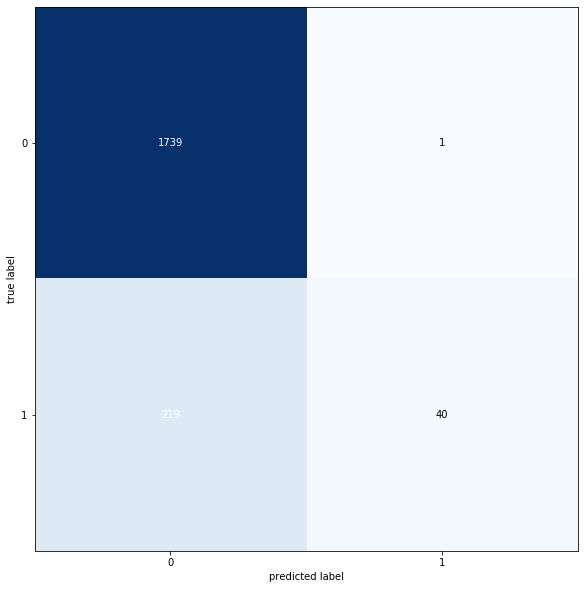

In [72]:
pred_r =rf_model.predict(X_test)
print(classification_report(y_test, pred_r))
plot_confusion_matrix(confusion_matrix(y_test, pred_r))

Try with SMOTE Over Sampling 

In [73]:
rf_smote_model = make_pipeline(StandardScaler(),SMOTE(), 
                    RandomizedSearchCV(RandomForestClassifier(), 
                    param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1))


# Fit the random search model
rf_smote_model.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 20.7min finished


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('smote',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=None,
                       sampling_strategy='auto')),
                ('randomizedsearchcv',
                 RandomizedSearchCV(cv=3, error_score=nan,
                                    estimator=RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max...
                                    param_distributions={'bootstrap': [True,
                                                                       False],
                                              

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1740
           1       0.72      0.10      0.18       259

    accuracy                           0.88      1999
   macro avg       0.80      0.55      0.56      1999
weighted avg       0.86      0.88      0.84      1999



(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1385c2d7648>)

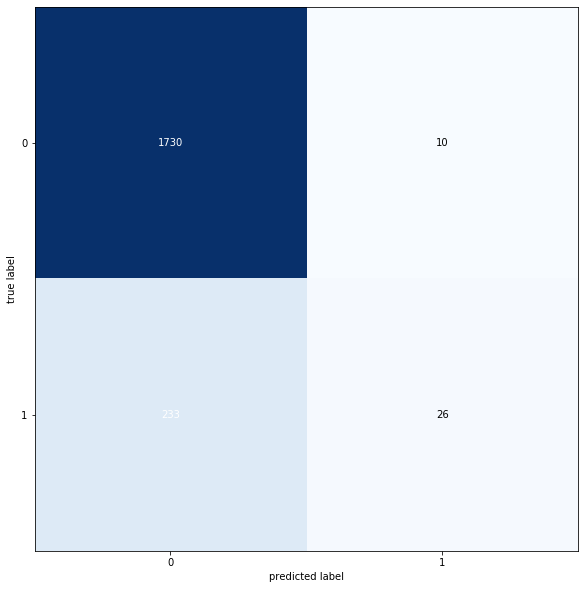

In [74]:
pred_r =rf_smote_model.predict(X_test)
print(classification_report(y_test, pred_r))
plot_confusion_matrix(confusion_matrix(y_test, pred_r))

Best parameters : {'class_weight': {0: 0.11413793103448276, 1: 0.8858620689655172}}


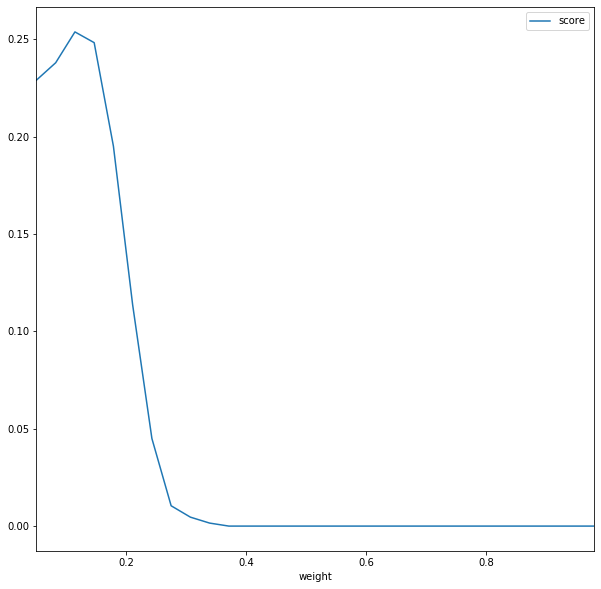

In [75]:
from sklearn.model_selection import GridSearchCV

weights = np.linspace(0.05, 0.98, 30)

gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=3,n_jobs=-1)

grid_result = gsc.fit(X, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

              precision    recall  f1-score   support

           0       0.92      0.56      0.70      1740
           1       0.18      0.66      0.29       259

    accuracy                           0.57      1999
   macro avg       0.55      0.61      0.49      1999
weighted avg       0.82      0.57      0.64      1999



(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13859aa14c8>)

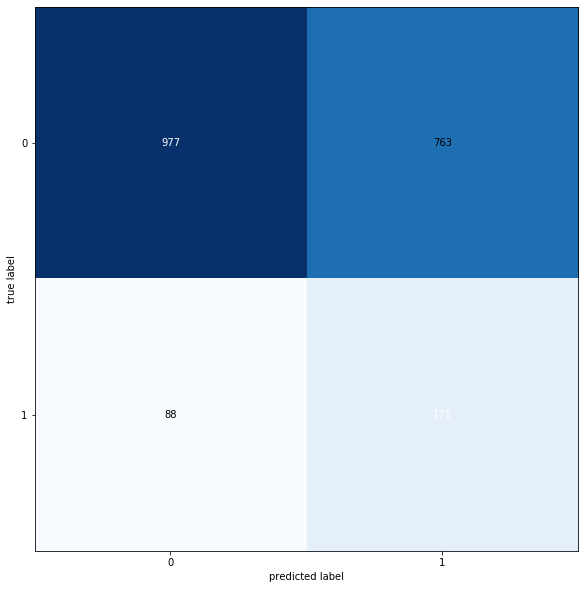

In [76]:
logit_model = LogisticRegression(**grid_result.best_params_)

# Fit..
logit_model.fit(X_train, y_train)

# Predict..
y_pred = logit_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

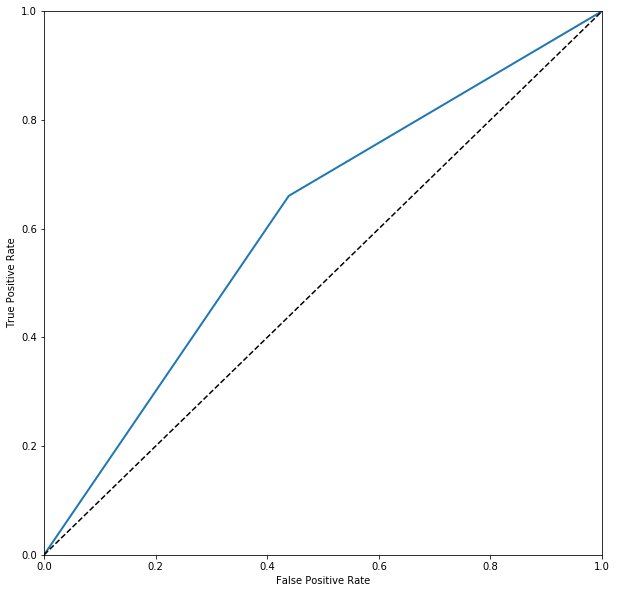

In [77]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

train neural network models for classification 
Multi-Layer PC - Perceptron Classifier We'll apply multi-layer perceptron (MLP) algorithm that trains using backpropagation. This model optimizes the log-loss function using 'lbfgs':
solver : {‘lbfgs’, ‘sgd’, ‘adam’}, default ‘adam’ The solver for weight optimization.
‘lbfgs’ is an optimizer in the family of quasi-Newton methods. ‘sgd’ refers to stochastic gradient descent. ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba

In [78]:
def makeOverSamplesSMOTE(X,y):
    sm = SMOTE(sampling_strategy='all')
    X, y = sm.fit_sample(X, y)
    return X,y
        
## SMOTE only on training data

X_train_ty, y_train_ty = makeOverSamplesSMOTE(X_train, y_train)

In [79]:
from sklearn.neural_network import MLPClassifier

neural_clf = MLPClassifier(solver = 'adam', alpha = 1e-5,activation='tanh', hidden_layer_sizes = (300,200), random_state = 42)
neural_clf.fit(X_train_ty, y_train_ty)


MLPClassifier(activation='tanh', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300, 200), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [80]:
pred_neural_clf = neural_clf.predict(X_test)

In [81]:
pred_ml_proba = neural_clf.predict_proba(X_test)[:,1]
pred_r =neural_clf.predict(X_test)

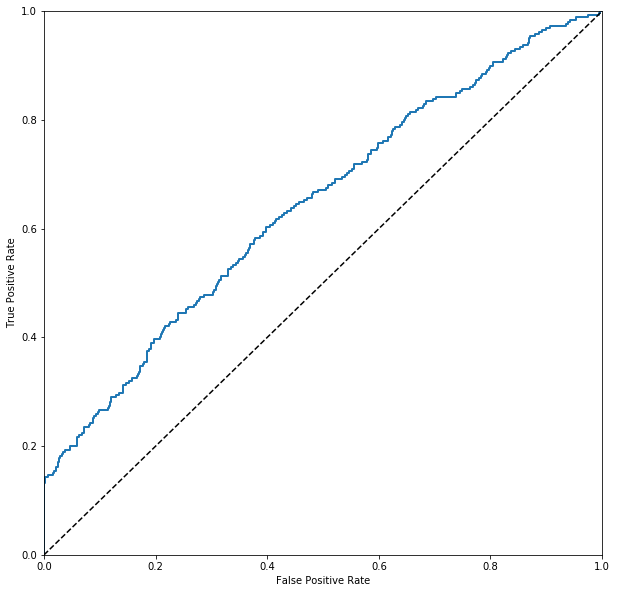

In [82]:
fpr, tpr, thresholds = roc_curve(y_test, pred_ml_proba)
plot_roc_curve(fpr, tpr)
plt.show()

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1740
           1       0.26      0.27      0.26       259

    accuracy                           0.81      1999
   macro avg       0.57      0.58      0.58      1999
weighted avg       0.81      0.81      0.81      1999



(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1385c8136c8>)

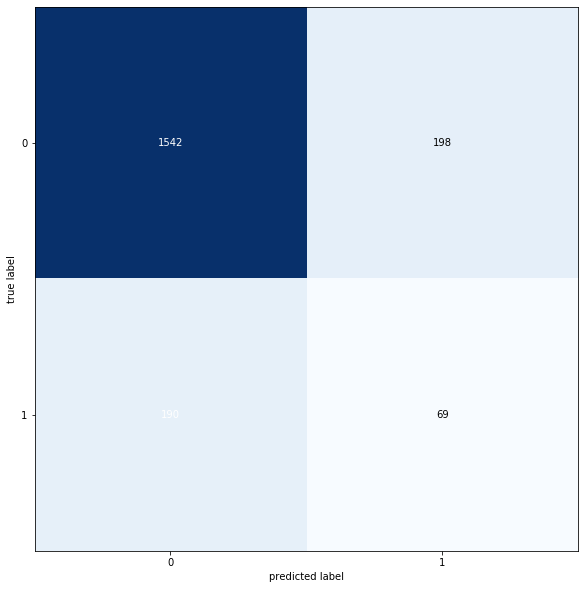

In [83]:
print(classification_report(y_test, pred_r))
plot_confusion_matrix(confusion_matrix(y_test, (pred_r)))

In [84]:
models = {
          "random forest": rf_model,
          "random forest SMOTE": rf_smote_model,
          "Logistic": logit_model,
          "Neural": neural_clf
         }

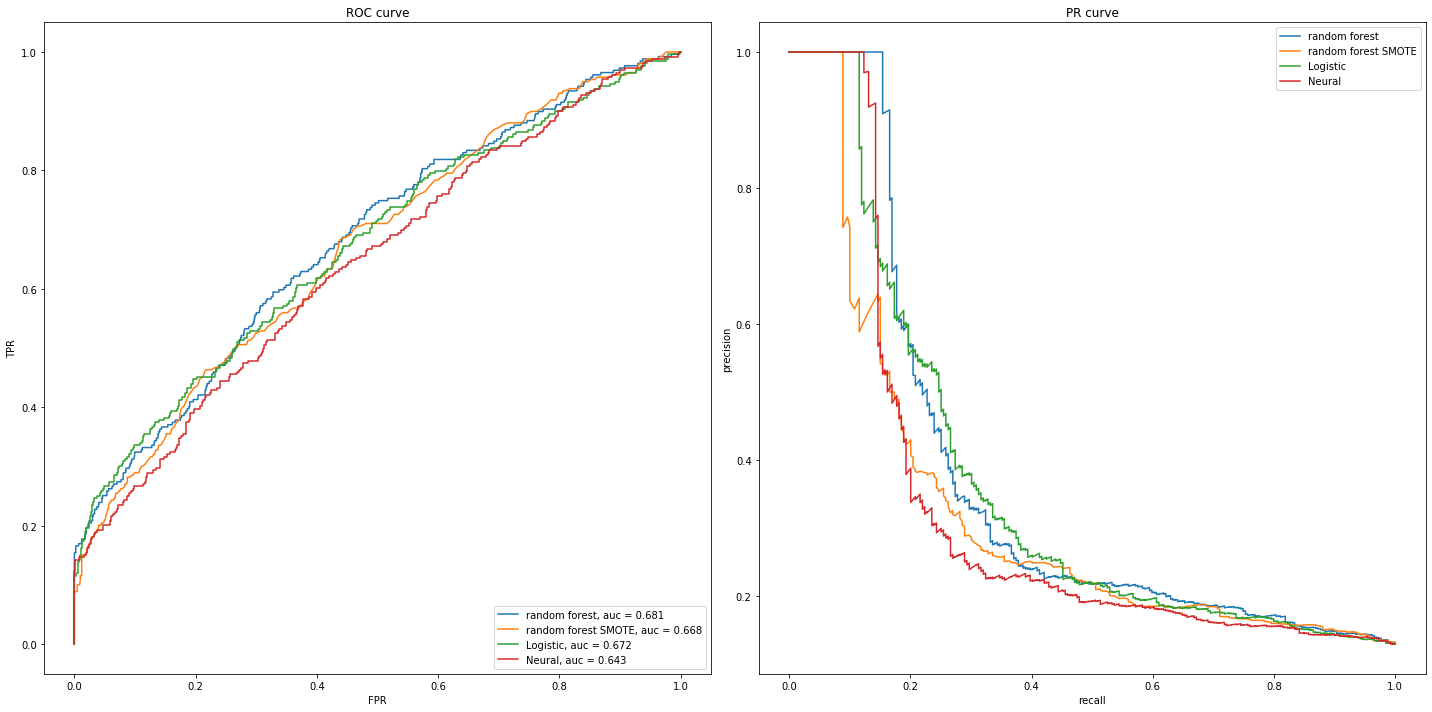

In [85]:
# Plot ROC and PR curves using all models and test data
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for name, model in models.items():    
    model_probs = model.predict_proba(X_test)[:, 1:]
    model_auc_score = roc_auc_score(y_test, model_probs)
    fpr, tpr, _ = roc_curve(y_test, model_probs)
    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    axes[0].plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
    axes[1].plot(recall, precision, label=f"{name}")    
    y_pred = np.argmax(model_probs, axis=1)


axes[0].legend(loc="lower right")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC curve")
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR curve")
plt.tight_layout()
   

This project focused on building different machine learning models and evaluating the performance of random forest, Neural network and logistic regression with imbalanced train data and balanced train data. We found that after oversampling the minority class by Synthetic Minority Over-Sampling Technique (SMOTE) in the training set, the recall score still not improves for every model,But class-weight penality works for especially logistic regression. The recall score indicates that the logistic regression can classify 67% of the applicants that will default. However, we can’t find a random forest model that works better than logistic regression and neural network.
logistic regression is likely to perform best when the signal to noise ratio is low, which in technical terms means that if the AUC of the best model is below 0.8, logistic very clearly outperformed tree induction. We think the complexity of our data, in other words low signal to noise ratio can be the reason why logistic regression performs best.
Besides the high recall score after using balanced data, logistic regression also has other benefits such as easy to interpret by viewing the parameters, that’s the reason we would recommend the financial institutions to use logistic regression to perform default prediction.

In [92]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
weight = {0: 0.11413793103448276, 1: 0.8858620689655172}

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_model = make_pipeline(StandardScaler(), 
                    RandomizedSearchCV(RandomForestClassifier(class_weight =weight), 
                    param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1))


# Fit the random search model
rf_model.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 32.2min finished


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomizedsearchcv',
                 RandomizedSearchCV(cv=10, error_score=nan,
                                    estimator=RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight={0: 0.11413793103448276,
                                                                                   1: 0.8858620689655172},
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                                                     max_leaf_node...
                                    p

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1740
           1       0.26      0.27      0.26       259

    accuracy                           0.81      1999
   macro avg       0.57      0.58      0.58      1999
weighted avg       0.81      0.81      0.81      1999



(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13808dd76c8>)

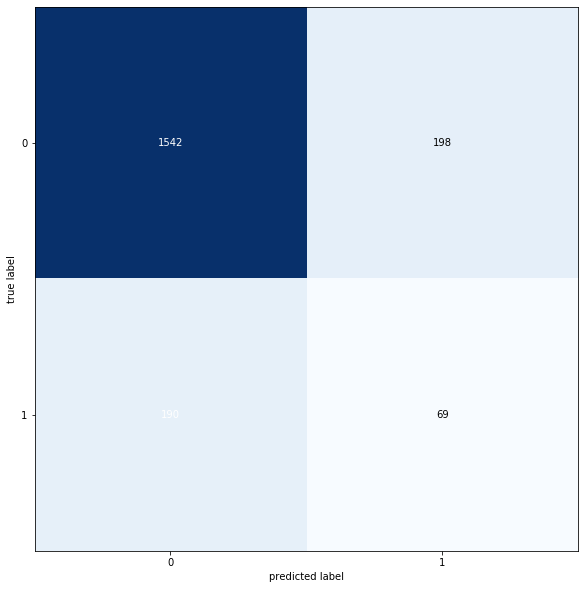

In [91]:

y_pred = rf_model.predict(X_test)

print(classification_report(y_test, pred_r))
plot_confusion_matrix(confusion_matrix(y_test, (pred_r)))

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
weight = {0: 0.11413793103448276, 1: 0.8858620689655172}

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_smote_weight_model = make_pipeline(StandardScaler(),SMOTE(), 
                    RandomizedSearchCV(RandomForestClassifier(class_weight =weight), 
                    param_distributions = random_grid, n_iter = 100, cv = 11, verbose=2, random_state=42, n_jobs = -1))


# Fit the random search model
rf_smote_weight_model.fit(X_train, y_train)

Fitting 11 folds for each of 100 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 52.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 84.5min
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed: 95.5min finished


              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1740
           1       0.26      0.27      0.26       259

    accuracy                           0.81      1999
   macro avg       0.57      0.58      0.58      1999
weighted avg       0.81      0.81      0.81      1999



(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x138089a4c08>)

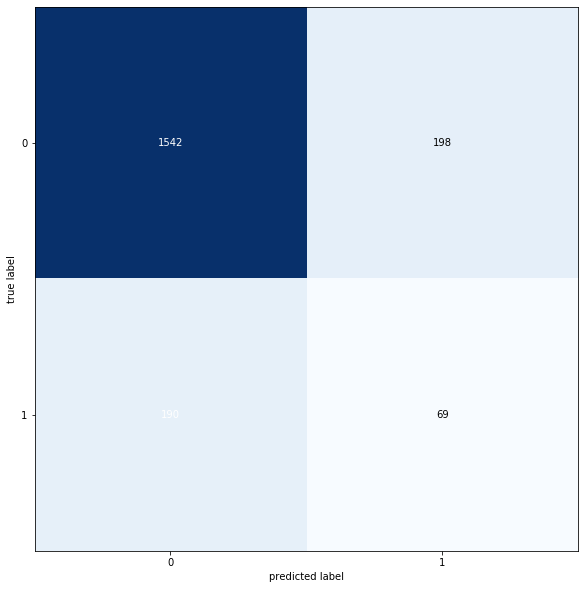

In [94]:
y_pred = rf_smote_weight_model.predict(X_test)

print(classification_report(y_test, pred_r))
plot_confusion_matrix(confusion_matrix(y_test, (pred_r)))

In [106]:
models = {
          "random forest": rf_model,
          "random forest SMOTE": rf_smote_weight_model,
         }

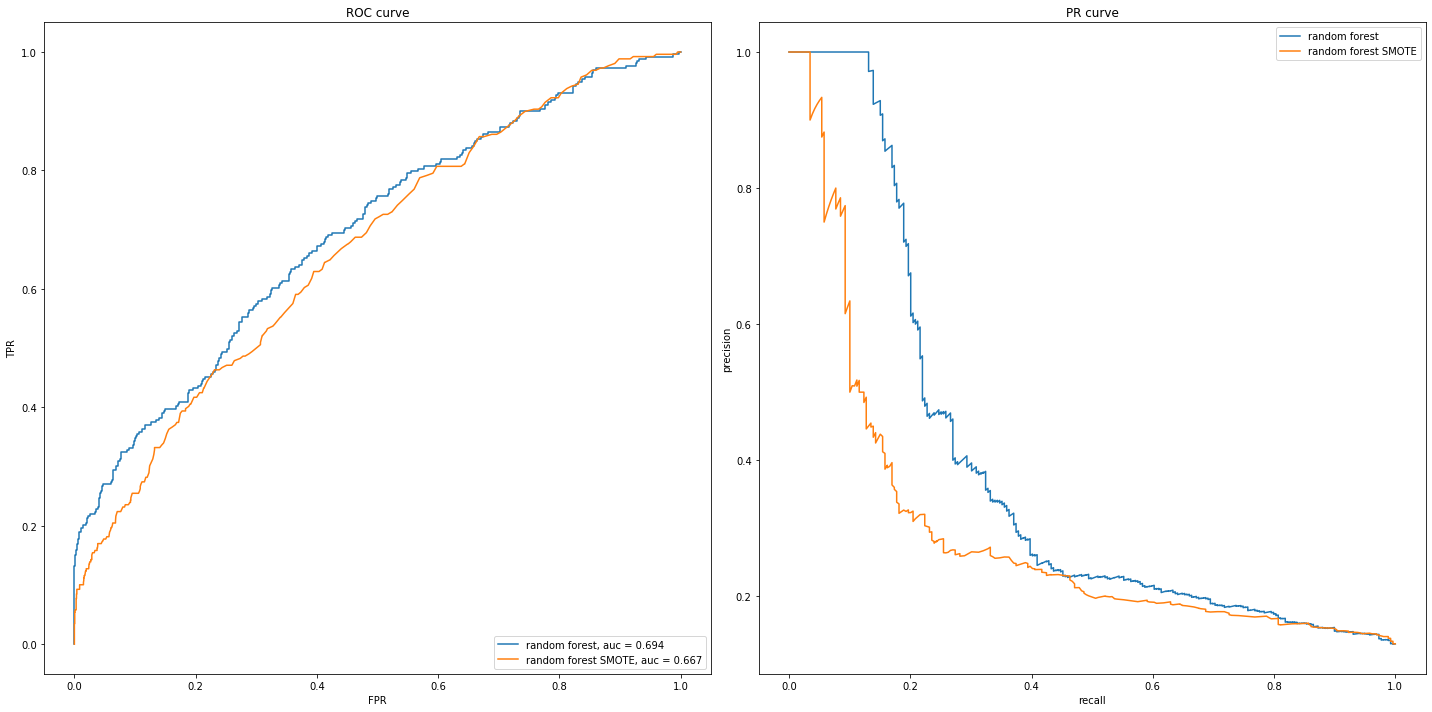

In [107]:
# Plot ROC and PR curves using all models and test data
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for name, model in models.items():    
    model_probs = model.predict_proba(X_test)[:, 1:]
    model_auc_score = roc_auc_score(y_test, model_probs)
    fpr, tpr, _ = roc_curve(y_test, model_probs)
    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    axes[0].plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
    axes[1].plot(recall, precision, label=f"{name}")    
    y_pred = np.argmax(model_probs, axis=1)


axes[0].legend(loc="lower right")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC curve")
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR curve")
plt.tight_layout()


9. Conclusion

We applied machine learning methods to predict the probability that a requested loan on LendingClub will charge off. After training and evaluating three different models (logistic regression, random forest, and k-nearest neighbors), we found that all three performed similarly according to a cross-validated AUROC score on the training data. We selected logistic regression (with ridge penalty) because it was the fastest model to train, and this model obtained an AUROC score of 0.689 on a test set consisting of the most recent 10% of the loans.

This model, while far from perfect, can provide a somewhat informed prediction of the likelihood that a loan will charge off, using only data available to potential investors before the loan is fully funded.



In [5]:
import pandas as pd

pd_loan1 =pd.read_csv("Loan_cheker.csv")
pd_loan1["Notes"]

0                                                     NaN
1         Borrower added on 04/14/11 > I will be using...
2                                                     NaN
3                                                     NaN
4       I want to consolidate my debt, pay for a vacat...
                              ...                        
9995                                                  NaN
9996    Borrower added on 08/30/11 > credit cards cons...
9997    Borrower added on 03/10/10 > My dream is to fi...
9998                                                  NaN
9999      Borrower added on 11/09/11 > order to pay ba...
Name: Notes, Length: 10000, dtype: object